In [49]:
import numpy as np
import pandas as pd
import requests
import pickle
import matplotlib.pyplot as plt
plt.style.use('https://raw.githubusercontent.com/benckj/mpl_style/main/uzh.mplstyle')
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates
from glob import glob
from datetime import datetime
from tqdm import tqdm

Extracting coins' listing time on Binance
===

In [5]:
file = '/local/scratch/yuzhang_utxo/token_price'
files = glob(file+'/*_minute_price.csv')             #all coins' price time series data
print(len(files))

token_list_time = dict()
# for f in files:
#     symbol = f.split("/")[-1].split("_")[0]
#     tp = pd.read_csv(f,header=0)
#     timestamp = int(tp.loc[0][1]/1000)
#     dt = datetime.fromtimestamp(timestamp)
#     token_list_time[symbol]=dt

# with open(file+'/all_tokens_listing_time.csv','wb') as f:
#     pickle.dump(token_list_time,f)

"""
 upload all coins' TokenName-ListingDate key-value pair that have been prepared 
 well by tokens price time series data on Binance.
"""
with open(file+'/all_tokens_listing_time.csv','rb') as f:          
    token_list_time = pickle.load(f)

print(token_list_time)

463
{'ENSUSDT': datetime.datetime(2021, 11, 10, 7, 0), 'KERNELUSDT': datetime.datetime(2025, 4, 14, 12, 0), 'MAVUSDT': datetime.datetime(2023, 6, 28, 8, 0), 'TONUSDT': datetime.datetime(2024, 8, 8, 10, 0), 'MTLUSDT': datetime.datetime(2019, 8, 23, 10, 0), 'DOLOUSDT': datetime.datetime(2025, 8, 27, 16, 0), 'VANAUSDT': datetime.datetime(2024, 12, 16, 11, 30), 'XTZUSDT': datetime.datetime(2019, 9, 24, 11, 0), 'INJUSDT': datetime.datetime(2020, 10, 21, 4, 0), 'CTKUSDT': datetime.datetime(2020, 10, 27, 8, 0), 'HOMEUSDT': datetime.datetime(2025, 6, 12, 15, 0), 'DYDXUSDT': datetime.datetime(2021, 9, 9, 2, 0), 'FDUSDUSDT': datetime.datetime(2023, 7, 26, 8, 0), 'EDUUSDT': datetime.datetime(2023, 4, 28, 12, 0), 'ACEUSDT': datetime.datetime(2023, 12, 18, 6, 0), '2ZUSDT': datetime.datetime(2025, 10, 2, 13, 0), 'ATAUSDT': datetime.datetime(2021, 6, 7, 6, 0), 'GMTUSDT': datetime.datetime(2022, 3, 9, 12, 0), 'KGSTUSDT': datetime.datetime(2025, 12, 24, 8, 0), 'AEURUSDT': datetime.datetime(2023, 12, 4,

In [6]:
date_tokens = dict()
date_tokens_num = dict()
for k,v in token_list_time.items():
    date_str = v.strftime('%Y-%m-%d')
    token_list_time[k] = date_str
    if date_str not in date_tokens:
        date_tokens[date_str] = [k]
        date_tokens_num[date_str] = 1
    else:
        date_tokens[date_str] = date_tokens[date_str]+[k]
        date_tokens_num[date_str] = date_tokens_num[date_str]+1

sorted_date_tokens_num = dict(sorted(date_tokens_num.items()))

listing_date = sorted_date_tokens_num.keys()
listing_token_num = sorted_date_tokens_num.values()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Source Sans Pro
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Source Sans Pro


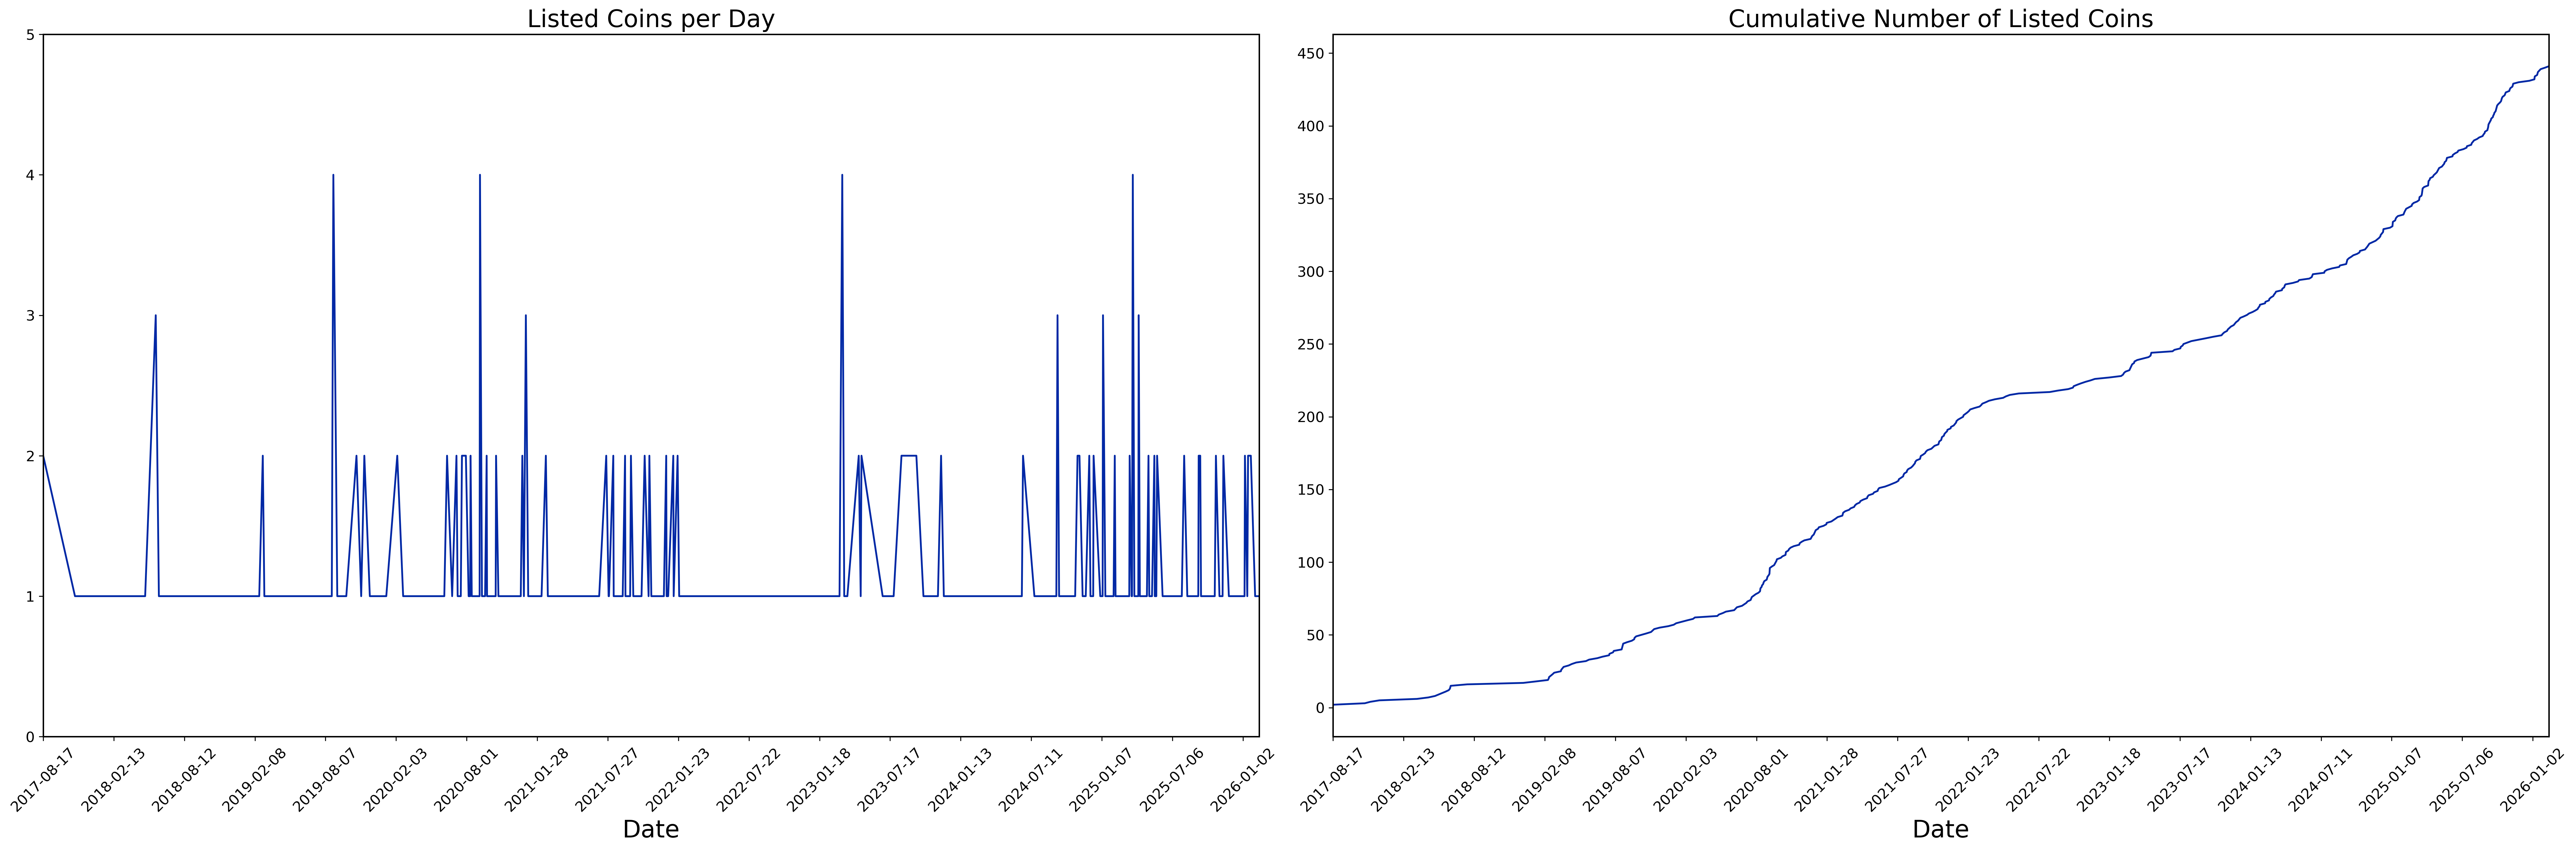

In [7]:
listing_date = np.array([k for k,v in sorted_date_tokens_num.items()])
# Convert listing_date (string) to datetime
listing_date = pd.to_datetime(listing_date)

listing_token_num = np.array([v for k, v in sorted_date_tokens_num.items()])
listing_token_num_sum = np.cumsum(listing_token_num)

fig = plt.figure(figsize=(30, 10))

# Create ticks from min to max date every 30 days
min_date = listing_date.min()
max_date = listing_date.max()
ticks = pd.date_range(start=min_date, end=max_date, freq="180D")

# Formatter
date_fmt = mdates.DateFormatter('%Y-%m-%d')

# -------- Plot 1 --------
ax1 = plt.subplot(121)
ax1.plot(listing_date, listing_token_num)

ax1.set_xticks(ticks)
ax1.set_xlim(min_date, max_date)
ax1.xaxis.set_major_formatter(date_fmt)

ax1.tick_params(axis='x', labelrotation=45)
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))

ax1.set_xlabel('Date', size=20)
ax1.set_title('Listed Coins per Day', size=20)
ax1.set_ylim(0,5)

# -------- Plot 2 --------
ax2 = plt.subplot(122)
ax2.plot(listing_date, listing_token_num_sum)

ax2.set_xticks(ticks)
ax2.set_xlim(min_date, max_date)
ax2.xaxis.set_major_formatter(date_fmt)

ax2.tick_params(axis='x', labelrotation=45)
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

ax2.set_xlabel('Date', size=20)
ax2.set_title('Cumulative Number of Listed Coins', size=20)

plt.tight_layout()
plt.show()

2.Plot significant coins' price time series
===

In [145]:
daily_new_files = glob(file+'/new_*_daily_price.csv')
daily_files = glob(file+'/*_daily_price.csv')
daily_old_files = [i for i in daily_files if 'new' not in i]

coin_to_analy = {}
for f in tqdm(daily_old_files):
    coin_usdt = pd.read_csv(f,header=0)
    d = np.array(coin_usdt['Close Time'])

    mindate = min(d)
    maxdate = max(d)
    # mindate = coin_usdt.loc[0]['Close Time']
    # maxdate = coin_usdt.loc[len(coin_usdt)-1]['Close Time']
    row_num = len(np.unique(d))
    effective_data_ratio = row_num/((maxdate-mindate)/60000/60/24+1)
    if row_num>365*6 and effective_data_ratio>0.95:
        coin_to_analy[f] = effective_data_ratio

print(len(coin_to_analy))

100%|██████████| 440/440 [00:01<00:00, 414.55it/s]

56


In [134]:
#here, tokens' names are provided as path names, such as '/local/scratch/yuzhang_utxo/token_price/new_BTCUSDT_daily_price.csv'. 
#they are the paths of corresponding tokens' price data as DataFrames

def calculate_coins_correlation(token1, token2):
    token1_usdt = pd.read_csv(token1,header = 0)
    token2_usdt = pd.read_csv(token2,header = 0)

    if token1_usdt.iloc[0]['Close Time']< token2_usdt.iloc[-1]['Close Time'] and token2_usdt.iloc[0]['Close Time']<token1_usdt.iloc[-1]['Close Time']:
        min_close_time = max(token1_usdt.iloc[0]['Close Time'],token2_usdt.iloc[0]['Close Time']) 
        max_close_time = min(token1_usdt.iloc[-1]['Close Time'],token2_usdt.iloc[-1]['Close Time']) 

    token1_usdt = token1_usdt.set_index('Close Time')
    token2_usdt = token2_usdt.set_index('Close Time')

    token1_price = token1_usdt.loc[min_close_time:max_close_time,'Close']
    token2_price = token2_usdt.loc[min_close_time:max_close_time,'Close']

    return np.corrcoef(token1_price,token2_price)[0,1]

In [146]:
tokens = np.array(list(coin_to_analy.keys()))
n = len(tokens)
corr_matrix = np.zeros((n, n))

for i, t1 in tqdm(enumerate(tokens)):
    for j, t2 in enumerate(tokens):
        try:
            corr_matrix[i][j] = calculate_coins_correlation(t1,t2)
        except:
            corr_matrix[i][j] = None

56it [00:24,  2.27it/s]


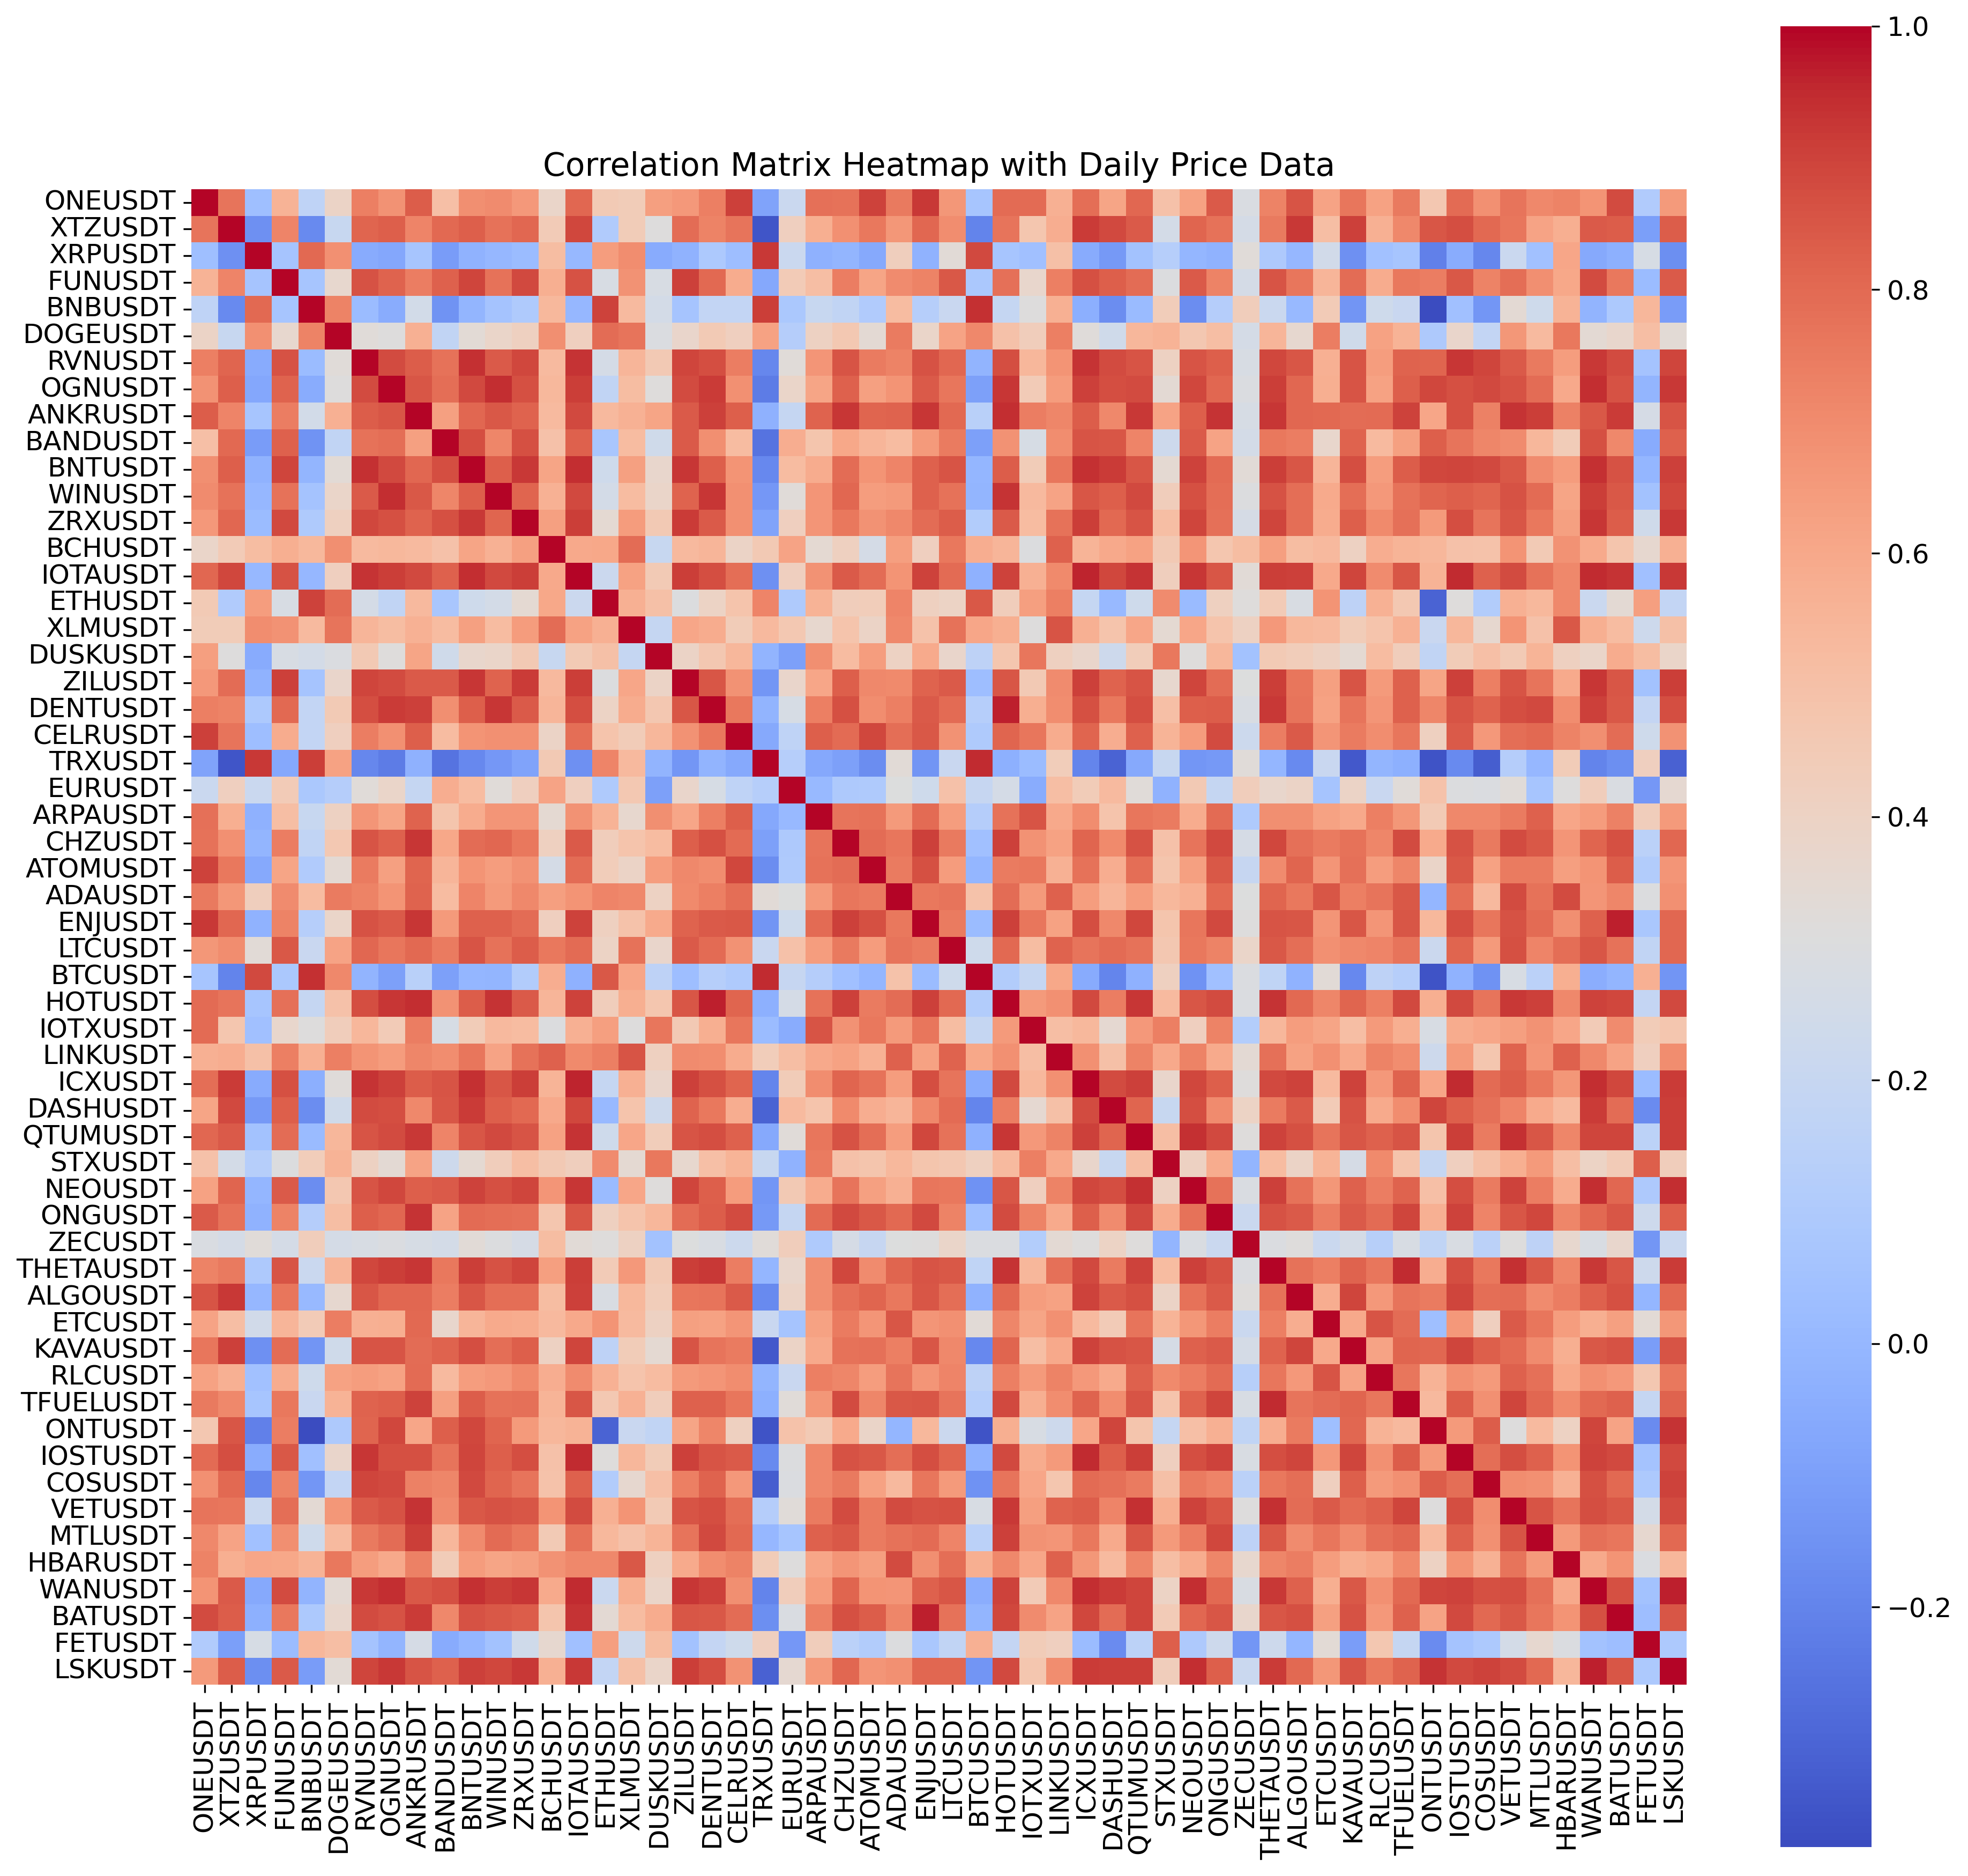

In [149]:
import seaborn as sns
token_names = [i.split('/')[-1].replace('_daily_price.csv', '') for i in tokens]

plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', square=True, xticklabels=token_names,
            yticklabels=token_names)
plt.title("Correlation Matrix Heatmap with Daily Price Data")
plt.savefig('image/heatmap.pdf',facecolor='white')

plt.show()